## Calculating historical and future projections of global warming in climate model simulations

Solution to Part 2 of Exercise in `00_calculate_simulated_global_warming.ipynb`

#### Python packages


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


## Data organization and processing workflow

This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from the fresh-off-the-supercomputers Phase 6 of the Coupled Model Intercomparison Project (CMIP6). 

#### Data catalogs

The file `https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv` in google cloud storage contains thousands of lines of metadata, each describing an individual climate model experiment's simulated data.

For example, the first line in the csv file contains the precipitation rate (`variable_id = 'pr'`), as a function of latitude, longitude, and time, in an individual climate model experiment with the BCC-ESM1 model (`source_id = 'BCC-ESM1'`) developed by the Beijing Climate Center (`institution_id = 'BCC'`). The model is *forced* by the forcing experiment SSP370 (`experiment_id = 'ssp370'`), which stands for the Shared Socio-Economic Pathway 3 that results in a change in radiative forcing of $\Delta F = 7.0$ W/m$^{2}$ from pre-industrial to 2100. This simulation was run as part of the `AerChemMIP` activity, which is a spin-off of the CMIP activity that focuses specifically on how aerosol chemistry affects climate.

In [23]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,prsn,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tas,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmin,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN


The file `pangeo-cmip6.json` describes the structure of the CMIP6 metadata and is formatted so as to be read in by the `intake.open_esm_datastore` method, which categorizes all of the data pointers into a tiered collection. For example, this collection contains the simulated data from 28691 individual experiments, representing 48 different models from 23 different scientific institutions. There are 190 different climate variables (e.g. sea surface temperature, sea ice concentration, atmospheric winds, dissolved organic carbon in the ocean, etc.) available for 29 different forcing experiments.

In [3]:
col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28691 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28691 zstore(s)

	> 59 dcpp_init_year(s)

Here, we show the various forcing experiments that climate modellers ran in these simulations. A few examples are:
 - `piControl` which fixes CO2 levels at pre-industrial concentrations of 300 ppm
 - `historical` which includes the historical evolution of greenhouse concentrations as well as historical volcanic eruptions, changes in solar luminosity, and changes in atmospheric aerosol concentrations (and some other, less impactful forcings).
 - `abrupt-4xCO2` in which the CO2 concentrations in an pre-industrial control simulation are abrupted quadrupled from 300 ppm to 1200 ppm.
 - `ssp585`, a `worst-case scenario` in which fossil-fueled development leads to a disastrous increase of $\Delta F = 8.5$ W/m$^{2}$ in radiative forcing (see description of the various SSP narratives below).

In [4]:
df['experiment_id'].unique()

array(['ssp370', 'esm-ssp585', '1pctCO2-bgc', 'hist-bgc', '1pctCO2',
       'abrupt-4xCO2', 'historical', 'piControl', 'amip', 'esm-hist',
       'esm-piControl', 'hist-GHG', 'hist-aer', 'hist-nat', 'dcppA-assim',
       'dcppA-hindcast', 'dcppC-hindcast-noAgung',
       'dcppC-hindcast-noElChichon', 'dcppC-hindcast-noPinatubo',
       'highresSST-present', 'control-1950', 'hist-1950',
       'deforest-globe', 'esm-ssp585-ssp126Lu', 'omip1', 'lgm', 'ssp126',
       'ssp245', 'ssp585'], dtype=object)

## Narratives of the CMIP6 Shared Socio-economic Pathways

See this excellent [in-depth explainer](https://www.carbonbrief.org/explainer-how-shared-socioeconomic-pathways-explore-future-climate-change) of the SSP's by Carbonbrief for more info.

#### SSP1: Sustainability – Taking the Green Road (Low challenges to mitigation and adaptation)
The world shifts gradually, but pervasively, toward a more sustainable path, emphasizing more inclusive development that respects perceived environmental boundaries. Management of the global commons slowly improves, educational and health investments accelerate the demographic transition, and the emphasis on economic growth shifts toward a broader emphasis on human well-being. Driven by an increasing commitment to achieving development goals, inequality is reduced both across and within countries. Consumption is oriented toward low material growth and lower resource and energy intensity.
#### SSP2: Middle of the Road (Medium challenges to mitigation and adaptation)
The world follows a path in which social, economic, and technological trends do not shift markedly from historical patterns. Development and income growth proceeds unevenly, with some countries making relatively good progress while others fall short of expectations. Global and national institutions work toward but make slow progress in achieving sustainable development goals. Environmental systems experience degradation, although there are some improvements and overall the intensity of resource and energy use declines. Global population growth is moderate and levels off in the second half of the century. Income inequality persists or improves only slowly and challenges to reducing vulnerability to societal and environmental changes remain.
#### SSP3: Regional Rivalry – A Rocky Road (High challenges to mitigation and adaptation)
A resurgent nationalism, concerns about competitiveness and security, and regional conflicts push countries to increasingly focus on domestic or, at most, regional issues. Policies shift over time to become increasingly oriented toward national and regional security issues. Countries focus on achieving energy and food security goals within their own regions at the expense of broader-based development. Investments in education and technological development decline. Economic development is slow, consumption is material-intensive, and inequalities persist or worsen over time. Population growth is low in industrialized and high in developing countries. A low international priority for addressing environmental concerns leads to strong environmental degradation in some regions.
#### SSP4: Inequality – A Road Divided (Low challenges to mitigation, high challenges to adaptation)
Highly unequal investments in human capital, combined with increasing disparities in economic opportunity and political power, lead to increasing inequalities and stratification both across and within countries. Over time, a gap widens between an internationally-connected society that contributes to knowledge- and capital-intensive sectors of the global economy, and a fragmented collection of lower-income, poorly educated societies that work in a labor intensive, low-tech economy. Social cohesion degrades and conflict and unrest become increasingly common. Technology development is high in the high-tech economy and sectors. The globally connected energy sector diversifies, with investments in both carbon-intensive fuels like coal and unconventional oil, but also low-carbon energy sources. Environmental policies focus on local issues around middle and high income areas.
#### SSP5: Fossil-fueled Development – Taking the Highway (High challenges to mitigation, low challenges to adaptation)
This world places increasing faith in competitive markets, innovation and participatory societies to produce rapid technological progress and development of human capital as the path to sustainable development. Global markets are increasingly integrated. There are also strong investments in health, education, and institutions to enhance human and social capital. At the same time, the push for economic and social development is coupled with the exploitation of abundant fossil fuel resources and the adoption of resource and energy intensive lifestyles around the world. All these factors lead to rapid growth of the global economy, while global population peaks and declines in the 21st century. Local environmental problems like air pollution are successfully managed. There is faith in the ability to effectively manage social and ecological systems, including by geo-engineering if necessary.

# Analysis of Climate Model Output Data

### Loading data

`intake-esm` enables loading data directly into an [xarray.DataArray](http://xarray.pydata.org/en/stable/api.html#dataset), a metadata-aware extension of numpy arrays. `xarray` objects leverage [dask](https://dask.org/) to only read data into memory as needed for any specific operation (i.e. lazy evaluation). Think of `xarray` Datasets as ways of conveniently organizing large arrays of floating point numbers (e.g. climate model data) on an n-dimensional discrete grid, with important metadata such as units, variable, names, etc.

Note that data on the cloud are in [zarr](https://zarr.readthedocs.io/en/stable/) format, an extension of the metadata-aware format [netcdf](https://www.unidata.ucar.edu/software/netcdf/) commonly used in geosciences.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [5]:
cat = col.search(experiment_id=['ssp585','historical'],  # pick the `historical` forcing experiment
                 table_id='Amon',             # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
                 variable_id='tas',           # choose to look at near-surface air temperature (tas) as our variable
                 member_id = 'r1i1p1f1')      # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)

In [6]:
time_slice = slice('1850','2100') # specific years that bracket our period of interest

In [14]:
# convert data catalog into a dictionary of xarray datasets
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

ds_dict = {}
gmst_dict = {}
for name, ds in tqdm(dset_dict.items()):
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
        
    ds = xr.decode_cf(ds) # temporary hack, not sure why I need this but has to do with calendar-aware metadata on the time variable
    ds = ds.sel(time=time_slice) # subset the data for the time period of interest
    
    # drop redundant variables (like "height: 2m")
    for coord in ds.coords:
        if coord not in ['lat','lon','time']:
            ds = ds.drop(coord)
    
    ## Calculate global-mean surface temperature (GMST)
    cos_lat_2d = np.cos(np.deg2rad(ds['lat'])) * xr.ones_like(ds['lon']) # effective area weights
    gmst = (
        (ds['tas'] * cos_lat_2d).sum(dim=['lat','lon']) /
        cos_lat_2d.sum(dim=['lat','lon'])
    )
    
    # Add GMST to dictionary
    gmst_dict[name] = gmst.squeeze()
    
    # Add near-surface air temperature to dictionary
    ds_dict[name] = ds

#### Splice together the historical (1850-2014) and SSP simulations (2015+)

In [15]:
ssp_dict = {}
for name, ds in ds_dict.items():
    for hist_name, hist_ds in ds_dict.items():
        if (name.split(".")[2] in hist_name) and ('historical' in hist_name):
            break
            
    if 'ssp' not in name: continue
        
    ssp_ds = xr.concat([hist_ds, ds],dim='time')
    ssp_dict[name] = ssp_ds

#### Example `xarray.DataArray`

The following is an example of an xarray.DataArray for the near-surface air temperature (`tas`) output from the MCM-UA climate model.

The dimensions `(member_id: 1, time: 1980, lat: 180, lon: 360)` signify that the 165 years of output is discretized into 1980 monthly-averages on a globe discretized into 180 1-degree latitdue bins and 360 longitude bins. The attributes of the DataArray describes various relevant metadata, such as a url for more info about the model, a reference publication which describes the simulation in detail, and the name of the model.


In [16]:
ssp_ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, member_id: 1, time: 3012)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time       (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: bnds, member_id
Data variables:
    height     (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(1980, 180, 2), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(1980, 288, 2), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 180, 288), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    bra

#### Visualizing warming patterns from 1890-1910 to 1990-2010

In [17]:
temperature_change = (
    ssp_ds['tas'].sel(time=slice('2080','2100')).mean(dim='time') -
    ssp_ds['tas'].sel(time=slice('1980','2000')).mean(dim='time')
).compute()
temperature_change.attrs.update(ssp_ds.attrs)
temperature_change = temperature_change.rename(
    r'temperature change ($^{\circ}$C) from 1980-2000 to 2080-2100'
)

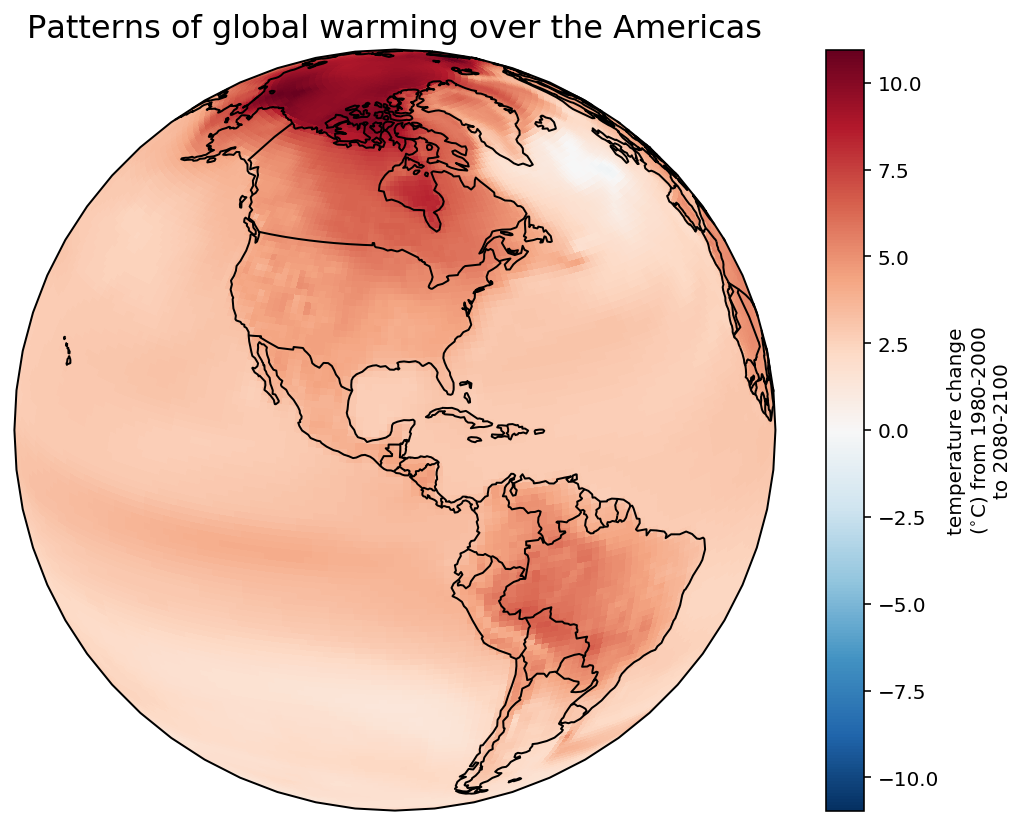

In [25]:
import cartopy.crs as ccrs
ortho = ccrs.Orthographic(-90, 20) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

plt.figure(figsize=(9,7))
ax = plt.subplot(1, 1, 1, projection=ortho)

q = temperature_change.plot(ax=ax, transform = geo) # plot a colormap in transformed coordinates

ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
plt.title('Patterns of global warming over the Americas',fontsize=16, ha='center');
plt.savefig('../figures/ssp585_warming_patterns.png',dpi=100,bbox_inches='tight')

#### Eagerly compute GMST for each model, in preparation for plotting

The operations we have done up to this point to calculate the global-mean surface temperature were evaluated lazily. In other worse, we have created a blueprint for how we want to evaluate the calculations, but have not yet computing them. This lets us do things like multiply two 1 Tb arrays together even though they are each individually larger-than-memory.

Now we call xarray's `compute()` method to carry out the computations we defined in the for loop above for calculation the global-mean surface temperature anomaly relative to the 1850-1900 mean.

#### Splice together

In [20]:
gmst_ssp_dict = {} # dictionary that will hold spliced DataArrays
for name, gmst in gmst_dict.items(): # Loop through dictionary
    if 'ssp' not in name: continue # keep only SSP simulations
            
    add_hist_gmst = None
    
    # Loop through dictionary to find matching historical simulation
    for hist_name, hist_gmst in gmst_dict.items():
        model_name = name.split(".")[2] # extract model name from name of simulation
        
        # find historical simulation that matches SSP simulation (same model)
        if (model_name in hist_name) and ('historical' in hist_name):
            add_hist_gmst = hist_gmst
    
    # if we found one, slice it together with the SSP and add it to the dictionary
    if add_hist_gmst is not None:
        gmst_ssp = xr.concat([add_hist_gmst, gmst],dim='time')
        gmst_ssp_dict[name] = gmst_ssp

In [21]:
for name, gmst in tqdm(gmst_ssp_dict.items()): # loop through each model
    
    # remove the climatological seasonal cycle from the signal, for visual clarity
    gmst_climatology = gmst.groupby('time.month').mean('time')
    gmst_anomalies = gmst.groupby('time.month') - gmst_climatology
    
    # reference the GMST relative to the 1850 to 1900 pre-industrial period
    gmst_anomalies = gmst_anomalies - gmst_anomalies.sel(time=slice('1850','1900')).mean(dim='time')
    
    # calculate annual-averages, to smooth the time-series a bit
    gmst_ann_anomalies = gmst_anomalies.groupby('time.year').mean('time')
    gmst_ann_anomalies = gmst_ann_anomalies.rename(
        r'global-mean surface temperature ($^{\circ}$C) (relative to 1900-1950)'
    )
    
    gmst_ssp_dict[name] = gmst_ann_anomalies.compute() # eager calculation of global-mean surface temperature

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
/srv/conda

#### Plotting a timeseries of global warming from 1850-2019

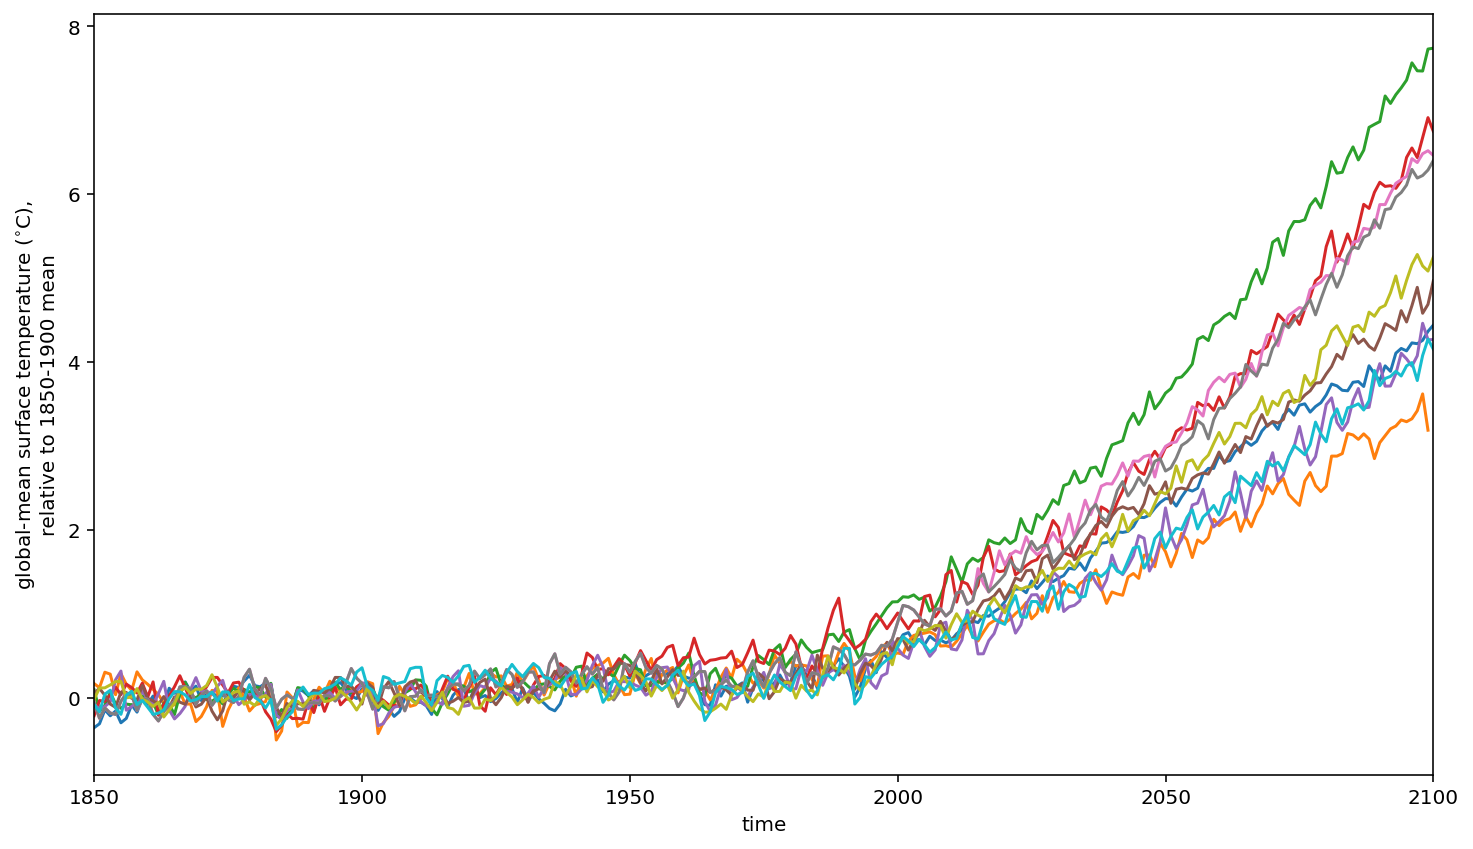

In [26]:
plt.figure(figsize=(12,7))

for name, gmst_ssp in gmst_ssp_dict.items():
    gmst_ssp.plot()
    
plt.xlabel('time')
plt.ylabel(r'global-mean surface temperature ($^{\circ}$C),'
           '\n'
           'relative to 1850-1900 mean')
plt.xlim([1850,2100]);
plt.savefig('../figures/ssp585_global_warming.png',dpi=100,bbox_inches='tight')